In [7]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import numpy as np
import jax.numpy as jnp
from jax import random
from jax import vmap
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',family ='Arial',size=10)
import pandas as pd
from jax.scipy.stats import norm 
import seaborn as sns

# GOH
Gasser et al 2006(https://doi.org/10.1098/rsif.2005.0073)


Incompressible material assumption
$$\Psi_1(J) = p(1-J)$$
$$\Psi_2(\mathbf{C}) = \frac{\mu}{2}(I_1 -3) +\frac{k_1}{2k_2}[e^{(k_2[\kappa I_1 + (1-3\kappa)I_4-1]^2)}-1]$$
Here $I_4 = \mathbf{C}:\mathbf{M} =\mathbf{C}:  \mathbf{a}_0\otimes \mathbf{a}_0$

Let $\mathbf{H} =\kappa \mathbf{I} + (1-3\kappa)\mathbf{M}$ 

and $H = \mathbf{H}:\mathbf{C}  =\kappa I_1 + (1-3\kappa)I_4$ and $E = [{H}-1]$

$$\mathbf{S}_1  = 2\frac{\partial \Psi_{1}}{\partial \mathbf{C}} = -pC^{-1} $$
$$\mathbf{S}_2  =  2\frac{\partial \Psi_{2}}{\partial \mathbf{C}} = \mu \mathbf{I} + 2k_1 e^{k_2{E}^2}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK2 stress

$$\mathbf{S} = -p\mathbf{C}^{-1} +  \mu\mathbf{I} + 2k_1 e^{k_2{E}^2}{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK1 stress

$$\mathbf{P} = \mathbf{F}\mathbf{S}$$

In [8]:
#### Here,the function to evaluate the stress considering the GOH model with two groups of fibers

def GOH(par, lmx, lmy, lmz):
    mu, k1, k2, kappa, alpha, k1_2, k2_2, kappa2, alpha2 = par
    mu = 0.05*(jnp.tanh(mu)+1)/2
    k1 = 99*(jnp.tanh(k1)+1)/2
    k2 = 1000*(jnp.tanh(k2)+1)/2
    kappa = 0.33*(jnp.tanh(kappa)+1)/2
    k1_2 = 100*(jnp.tanh(k1_2)+1)/2
    k2_2 = 1000*(jnp.tanh(k2_2)+1)/2
    kappa2 = 0.33*(jnp.tanh(kappa2)+1)/2

    
    a1 = jnp.array([jnp.cos(alpha),jnp.sin(alpha),0])
    a2 = jnp.array([jnp.cos(alpha2),jnp.sin(alpha2),0])
    M1 = jnp.outer(a1,a1)
    M2 = jnp.outer(a2,a2)

    F = jnp.array([[lmx, 0, 0],
                    [0, lmy, 0],
                    [0, 0, lmz]])
    C = jnp.dot(F.T,F)
    invC = jnp.linalg.inv(C)
    I = jnp.eye(3)
    I1 = C[0,0] + C[1,1] + C[2,2]  ## trace of C
    I4 = jnp.tensordot(C,M1)
    I4_2 = jnp.tensordot(C,M2)

    H1 = kappa*I1+(1-3*kappa)*I4
    H2 = kappa2*I1+(1-3*kappa2)*I4_2
    E1 = H1-1.0
    E2 = H2-1
    S2 = mu*I+2*k1*jnp.exp(k2*E1**2)*E1*(kappa*I+(1-3*kappa)*M1)+2*k1_2*jnp.exp(k2_2*E2**2)*E2*(kappa2*I+(1-3*kappa2)*M2)
    p = S2[2,2]/invC[2,2]
    S = -p*invC+S2

    sgm = jnp.dot(F,jnp.dot(S,F.T))

    return sgm[0,0], sgm[1,1]

GOH_vmap = vmap(GOH, in_axes=(0,0,0,0), out_axes=(0,0))
GOH_vmap2 = vmap(GOH, in_axes=(None,0,0,0), out_axes=(0,0))

In [9]:
# Load the data
OffX_3C1      = pd.read_csv('Control/PK_lam_OffX_3C.csv').to_numpy()[:,1:]
OffX_6CS11    = pd.read_csv('Control/PK_lam_OffX_6CS1.csv').to_numpy()[:,1:]
OffX_P9C11    = pd.read_csv('Control/PK_lam_OffX_P9C1.csv').to_numpy()[:,1:]
OffX_P10C1S11 = pd.read_csv('Control/PK_lam_OffX_P10C1S1.csv').to_numpy()[:,1:]

OffY_3C1      = pd.read_csv('Control/PK_lam_OffY_3C.csv').to_numpy()[:,1:]
OffY_6CS11    = pd.read_csv('Control/PK_lam_OffY_6CS1.csv').to_numpy()[:,1:]
OffY_P9C11    = pd.read_csv('Control/PK_lam_OffY_P9C1.csv').to_numpy()[:,1:]
# OffY_P10C1S11 = pd.read_csv('Control/PK_lam_OffY_P10C1S1.csv').to_numpy()[:,1:]

vecze  = jnp.ones((len(OffX_3C1),1))
vecze2 = jnp.ones((len(OffX_6CS11),1))
vecze3 = jnp.ones((len(OffX_P9C11),1))
vecze4 = jnp.ones((len(OffX_P10C1S11),1))

vecze11  = jnp.ones((len(OffY_3C1),1))
vecze22 = jnp.ones((len(OffY_6CS11),1))
vecze33 = jnp.ones((len(OffY_P9C11),1))
# vecze44 = jnp.ones((len(OffY_P10C1S11),1))

OffX_3C       = jnp.hstack([0*vecze,OffX_3C1,0*vecze])
OffX_6CS1     = jnp.hstack([1*vecze2,OffX_6CS11,0*vecze2])
OffX_P9C1     = jnp.hstack([2*vecze3,OffX_P9C11,0*vecze3])
OffX_P10C1S1  = jnp.hstack([3*vecze4,OffX_P10C1S11,0*vecze4])

OffY_3C       = jnp.hstack([0*vecze11,OffY_3C1,1*vecze11])
OffY_6CS1     = jnp.hstack([1*vecze22,OffY_6CS11,1*vecze22])
OffY_P9C1     = jnp.hstack([2*vecze33,OffY_P9C11,1*vecze33])
# OffY_P10C1S1  = jnp.hstack([3*vecze44,OffY_P10C1S11])

OffXall = jnp.vstack([OffX_3C,OffX_6CS1,OffX_P9C1
                   ,OffX_P10C1S1
                  ]).T

OffYall = jnp.vstack([OffY_3C,OffY_6CS1,OffY_P9C1
                #    ,OffY_P10C1S1
                  ]).T
                
OffXandY=jnp.hstack([OffXall,OffYall])

                
n_samples=4
data = np.zeros([6,jnp.shape(OffXandY)[1]]) # data: [sample id, lambda_x, lambda_y, sigma_xx, sigma_yy, boolean(0 for OffX, 1 OffY)] <-- contains this variables as columns

data[0,:]=OffXandY[0,:]
data[1,:]=OffXandY[1,:]
data[2,:]=OffXandY[3,:]
data[3,:]=OffXandY[2,:]
data[4,:]=OffXandY[4,:]
data[5,:]=OffXandY[5,:]

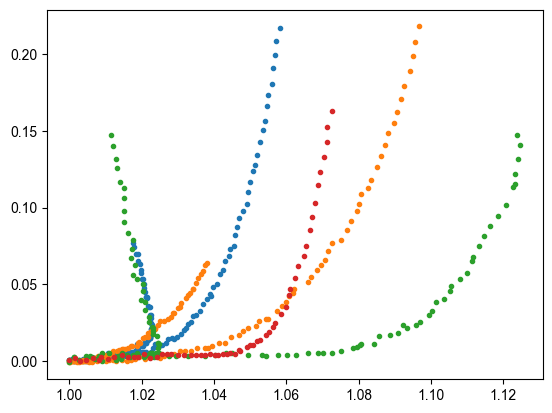

In [10]:
for i_sample in [0,1,2,3]:
    sample_lmx  = data[1,data[0,:]==i_sample]
    sample_lmy  = data[2,data[0,:]==i_sample]
    sample_sgmx = data[3,data[0,:]==i_sample]
    sample_sgmy = data[4,data[0,:]==i_sample]
    plt.plot(sample_lmy, sample_sgmy, '.')

In [11]:
n_params = 9
def model(i_sample, lmx, lmy, sgmx_gt=None, sgmy_gt=None):
    # Individual parameters
    L_i = numpyro.sample('L_i', dist.Normal(0,1), sample_shape=(n_params,n_params))
    K_i = L_i @ L_i.T
    mu_i = numpyro.sample('mu_i', dist.Normal(0,1), sample_shape=(n_params,))
    with numpyro.plate('plate_i', n_samples):
        params_i = numpyro.sample('params_i', dist.MultivariateNormal(mu_i, K_i))
        
    lmz = 1.0/(lmx*lmy)
    sgmx_pr, sgmy_pr = GOH_vmap(params_i[i_sample], lmx, lmy, lmz)
    sgm_noise = numpyro.sample('sgm_noise', dist.HalfNormal(0.005))
    with numpyro.plate('data', len(lmx)):
        numpyro.sample('obs_sgmx', dist.Normal(sgmx_pr,sgm_noise), obs=sgmx_gt)
        numpyro.sample('obs_sgmy', dist.Normal(sgmy_pr,sgm_noise), obs=sgmy_gt)

In [12]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000) # use 20000 and 200000
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, data[0,:].astype(int), data[1,:], data[2,:], data[3,:], data[4,:])

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [10:51<00:00,  6.14it/s, 1023 steps of size 8.67e-05. acc. prob=0.82]


In [13]:
sam1=posterior_samples["params_i"][:,0,:]
CTRL1d = pd.DataFrame(data=sam1, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
CTRL1d.to_csv('CTRL1.csv')

sam2=posterior_samples["params_i"][:,1,:]
CTRL2d = pd.DataFrame(data=sam2, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
CTRL2d.to_csv('CTRL2.csv')

sam3=posterior_samples["params_i"][:,2,:]
CTRL3d = pd.DataFrame(data=sam3, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
CTRL3d.to_csv('CTRL3.csv')

sam4=posterior_samples["params_i"][:,3,:]
CTRL4d = pd.DataFrame(data=sam4, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
CTRL4d.to_csv('CTRL4.csv')

In [14]:
posterior_samples['params_i'].shape

(2000, 4, 9)

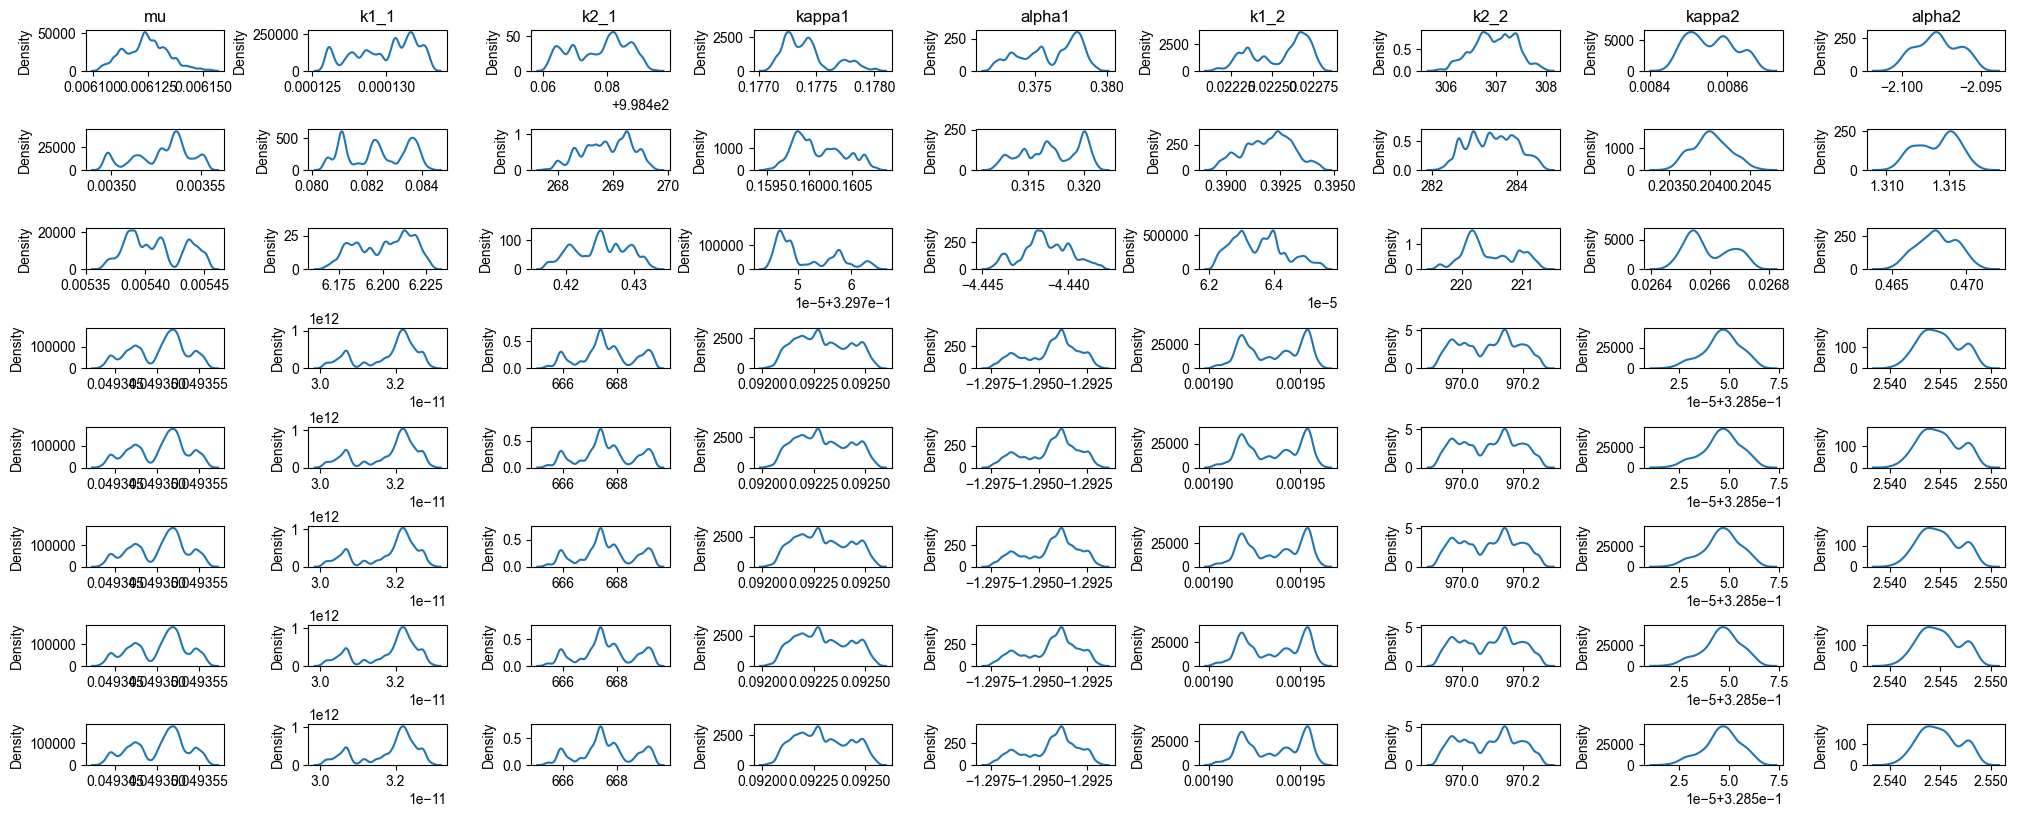

In [15]:
fig, ax = plt.subplots(8, 9, figsize=(20, 8))

for i in range(8):
    sns.kdeplot(np.array(0.05*norm.cdf(posterior_samples["params_i"][:, i, 0])), ax=ax[i,0], bw_method=0.1, label='')
    sns.kdeplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 1])), ax=ax[i,1], bw_method=0.1)
    sns.kdeplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 2])), ax=ax[i,2], bw_method=0.1)
    sns.kdeplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 3])), ax=ax[i,3], bw_method=0.1)
    sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4], bw_method=0.1)
    sns.kdeplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 5])), ax=ax[i,5], bw_method=0.1)
    sns.kdeplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 6])), ax=ax[i,6], bw_method=0.1)
    sns.kdeplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 7])), ax=ax[i,7], bw_method=0.3)
    sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8], bw_method=0.3)

# sns.kdeplot(data2, ax=ax[1,1], label='Distribution 2')

ax[0,0].set_title('mu')
ax[0,1].set_title('k1_1')
ax[0,2].set_title('k2_1')
ax[0,3].set_title('kappa1')
ax[0,4].set_title('alpha1')
ax[0,5].set_title('k1_2')
ax[0,6].set_title('k2_2')
ax[0,7].set_title('kappa2')
ax[0,8].set_title('alpha2')

# ax[2,3].spines['left'].set_visible(False)
# ax[0,8].spines['top'].set_visible(False)

# ax[0,0].legend()
# ax[1,0].legend()
# ax[0,1].legend()
# ax[1,1].legend()

# # plt.legend()
# plt.savefig("PosteriorParams_iCTRL2.png",dpi=300)
fig.tight_layout(pad=0.1)

plt.show()

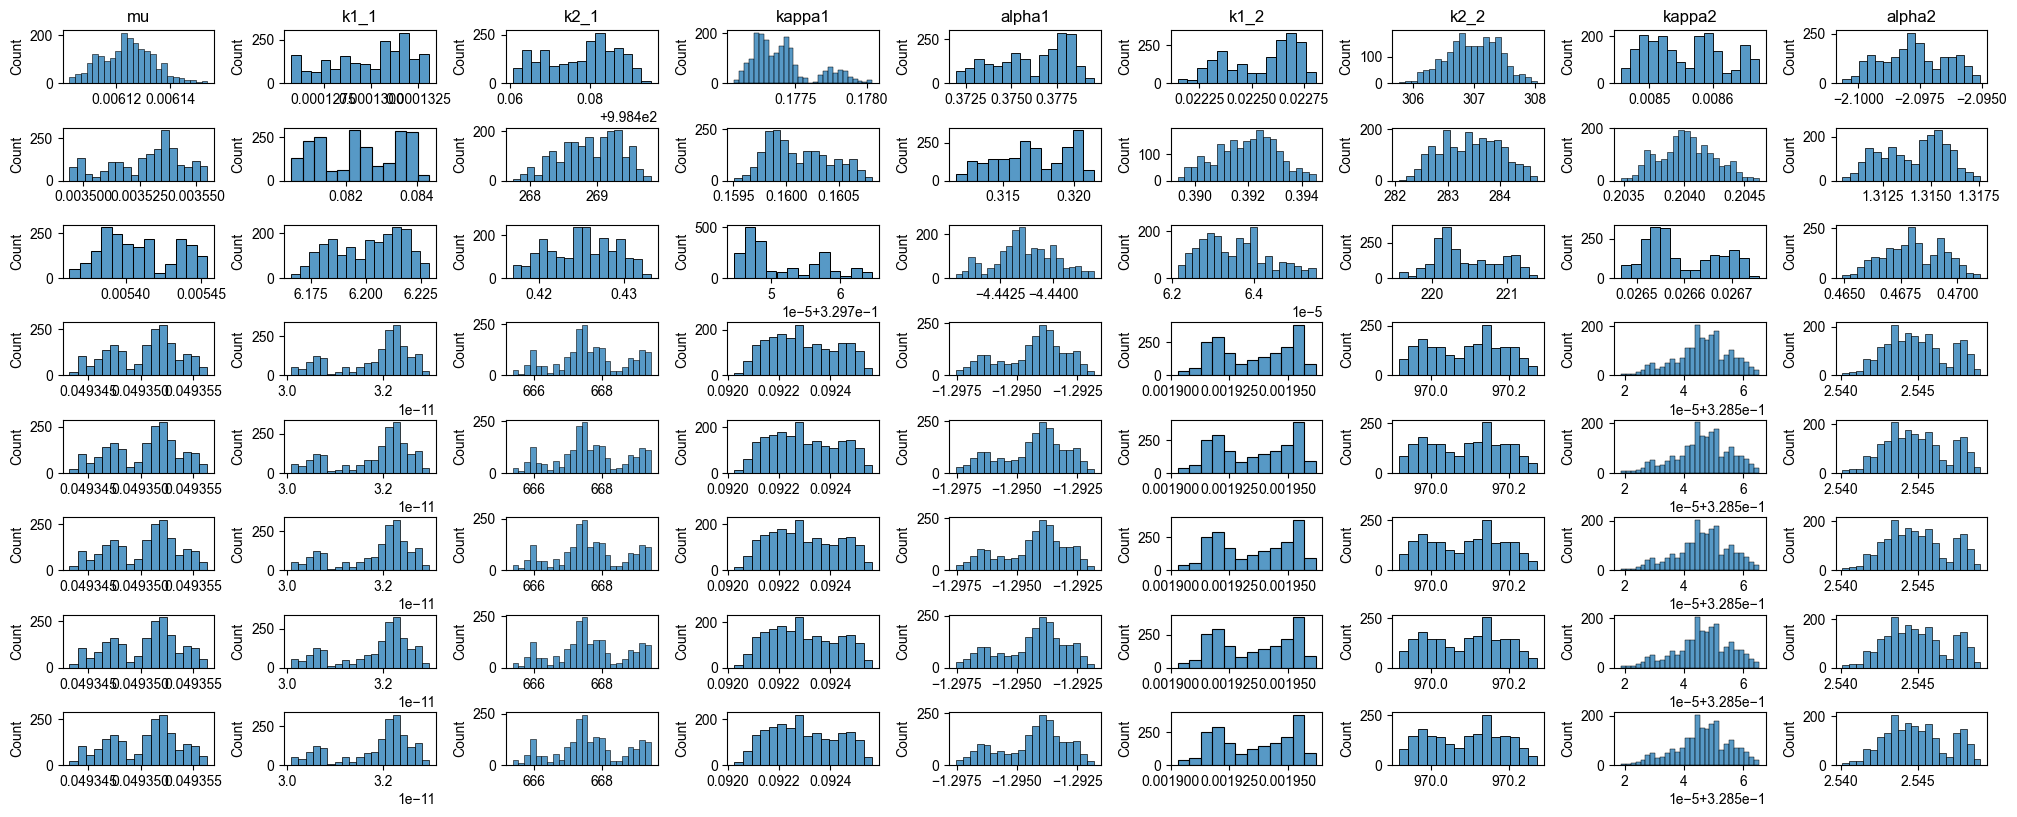

In [16]:
fig, ax = plt.subplots(8, 9, figsize=(20, 8))

for i in range(8):
    # sns.kdeplot(np.array(0.05*norm.cdf(posterior_samples["params_i"][:, i, 0])), ax=ax[i,0], bw_method=0.3, label='')
    # sns.kdeplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 1])), ax=ax[i,1], bw_method=0.3)
    # sns.kdeplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 2])), ax=ax[i,2], bw_method=0.3)
    # sns.kdeplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 3])), ax=ax[i,3], bw_method=0.3)
    # sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4], bw_method=0.3)
    # sns.kdeplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 5])), ax=ax[i,5], bw_method=0.3)
    # sns.kdeplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 6])), ax=ax[i,6], bw_method=0.3)
    # sns.kdeplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 7])), ax=ax[i,7], bw_method=0.3)
    # sns.kdeplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8], bw_method=0.3)

    sns.histplot(np.array(0.05*norm.cdf(posterior_samples["params_i"][:, i, 0])), ax=ax[i,0])
    sns.histplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 1])), ax=ax[i,1])
    sns.histplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 2])), ax=ax[i,2])
    sns.histplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 3])), ax=ax[i,3])
    sns.histplot(np.array(posterior_samples["params_i"][:, i, 4]), ax=ax[i,4])
    sns.histplot(np.array(100*norm.cdf(posterior_samples["params_i"][:, i, 5])), ax=ax[i,5])
    sns.histplot(np.array(1000*norm.cdf(posterior_samples["params_i"][:, i, 6])), ax=ax[i,6])
    sns.histplot(np.array(0.33*norm.cdf(posterior_samples["params_i"][:, i, 7])), ax=ax[i,7])
    sns.histplot(np.array(posterior_samples["params_i"][:, i, 8]), ax=ax[i,8])


# sns.kdeplot(data2, ax=ax[1,1], label='Distribution 2')

ax[0,0].set_title('mu')
ax[0,1].set_title('k1_1')
ax[0,2].set_title('k2_1')
ax[0,3].set_title('kappa1')
ax[0,4].set_title('alpha1')
ax[0,5].set_title('k1_2')
ax[0,6].set_title('k2_2')
ax[0,7].set_title('kappa2')
ax[0,8].set_title('alpha2')

# ax[2,3].spines['left'].set_visible(False)
# ax[0,8].spines['top'].set_visible(False)

# ax[0,0].legend()
# ax[1,0].legend()
# ax[0,1].legend()
# ax[1,1].legend()

# # plt.legend()
# plt.savefig("PosteriorParams_iCTRL.png",dpi=300)
fig.tight_layout(pad=0.1)

In [ ]:
# import arviz as az

# outdata = az.from_numpyro(mcmc)
# az.plot_trace(outdata, compact=True, figsize=(15, 25)); 

In [17]:
TableM=np.zeros((4,9))
print(np.shape(TableM))
for i in range(4):
    for j in range(9):
        x=posterior_samples['params_i'][:,i,j]
        if j!=4 and j!=8:
            if j==3 or j==7:
                for m in range(len(x)):
                    x = x.at[m].set(0.33*(jnp.tanh(x[m])+1)/2)
            elif j==1 or j==5:
                for m in range(len(x)):
                    x = x.at[m].set(100*(jnp.tanh(x[m])+1)/2)
            elif j==2 or j==6:
                for m in range(len(x)):
                    x = x.at[m].set(1000*(jnp.tanh(x[m])+1)/2)
            elif j==0:
                for m in range(len(x)):
                    x = x.at[m].set(0.05*(jnp.tanh(x[m])+1)/2)
            # else:
            #     for m in range(len(x)):
            #         x = x.at[m].set(jnp.exp(x[m]))

        TableM[i,j]=np.median(x)
        # TableM[i,j]=np.median(x)

print(TableM)

# CTRLcsv = pd.DataFrame(data=TableM, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
# CTRLcsv.to_csv('CTRLcsv.csv')


(4, 9)
[[ 4.45242459e-03  8.28206539e-03  9.97341309e+02  1.80485666e-01
   3.76683086e-01  8.97347927e-02  2.67220551e+02  6.61824737e-03
  -2.09778762e+00]
 [ 2.50600744e-03  1.84267759e-01  2.25797058e+02  1.58783674e-01
   3.17019582e-01  4.88013029e-01  2.41330566e+02  2.13189453e-01
   1.31454480e+00]
 [ 3.88766918e-03  4.41133070e+00  1.26463175e+00  3.29419374e-01
  -4.44142962e+00  6.19590282e-03  1.76210114e+02  1.88560225e-02
   4.68022585e-01]
 [ 4.94249463e-02  5.96046448e-05  7.03920776e+02  7.82904029e-02
  -1.29407287e+00  2.66551971e-02  9.77346741e+02  3.28258276e-01
   2.54471588e+00]]


In [18]:
CTRLcsv = pd.DataFrame(data=TableM, index=None, columns=['mu','k1_1','k2_1','kappa','alpha','k2_1','k2_2','kappa2','alpha2'], dtype=None, copy=False)
# CTRLcsv.to_csv('CTRLcsv.csv')

In [19]:
predictive = Predictive(model, posterior_samples)
samples_predictive = predictive(random.PRNGKey(1), data[0,:].astype(int), data[1,:], data[2,:], None, None)

(479,)
(479,)
(479,)
(479,)


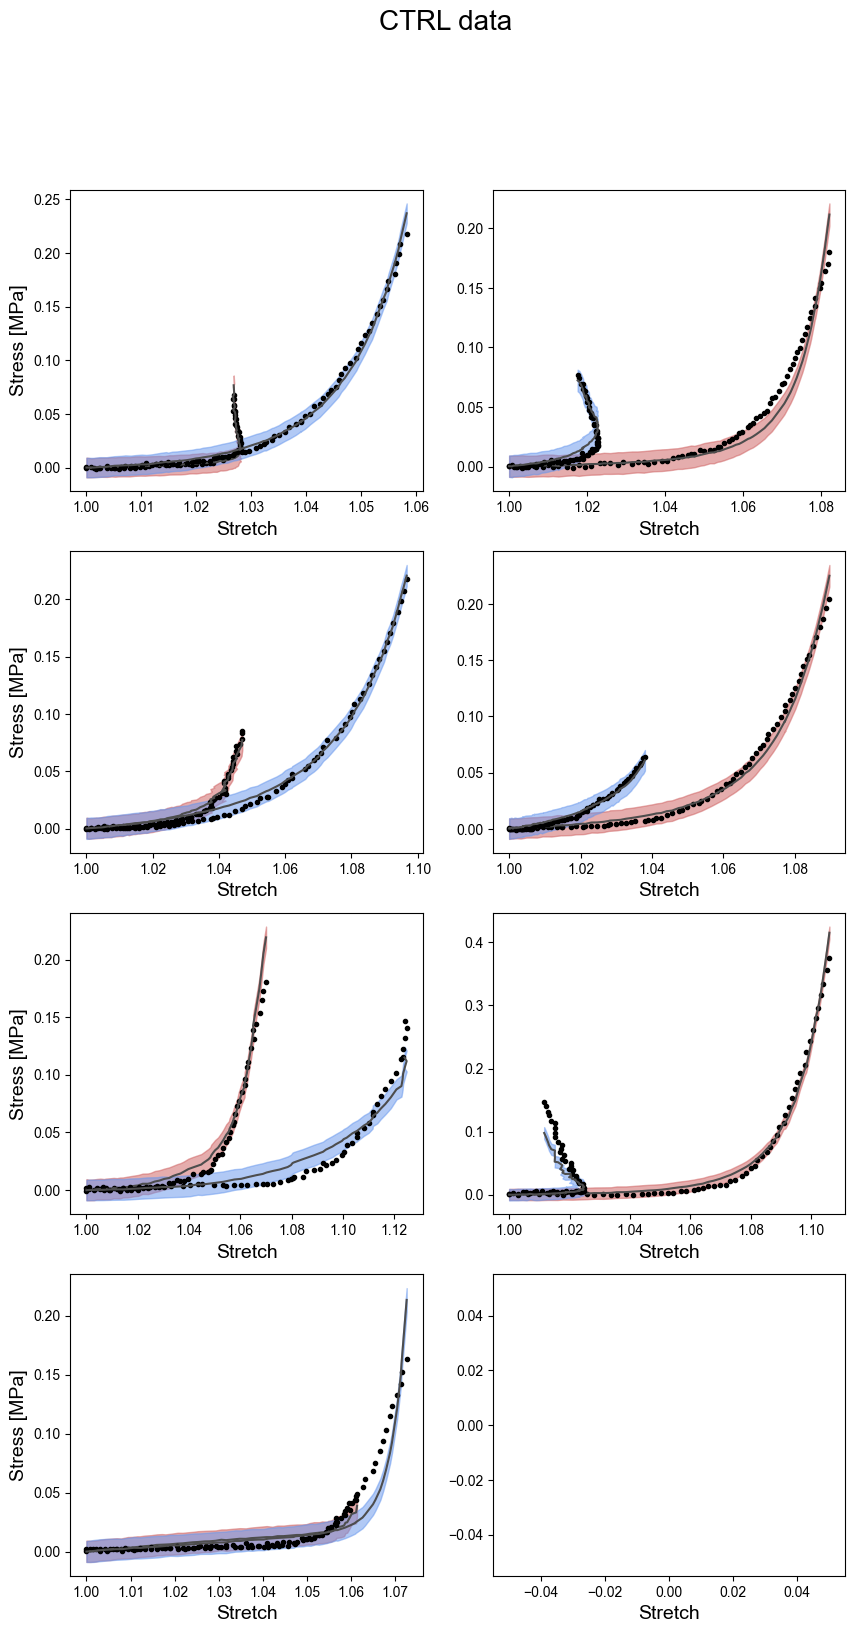

In [20]:
fig, axes = plt.subplots(4,2,figsize=(10,18))

for ax, i_sample in zip(axes, [0,1,2,3]):
    sgmx_pr = samples_predictive['obs_sgmx']
    sgmy_pr = samples_predictive['obs_sgmy']    

    idx = (data[0,:]==i_sample) & (data[5,:]==0)
    # print(idx)
    x = data[1,idx]
    y = data[2,idx]
    # print(x)
    sgmx_gt = data[3,idx] ##sigma real
    sgmx_std = sgmx_pr.std(axis=0)[idx] 
    sgmx_pr = sgmx_pr.mean(axis=0)[idx]
    sgmx_inf = sgmx_pr-sgmx_std
    sgmx_sup = sgmx_pr+sgmx_std

    # if np.all(data[5,:]==0):
    ax[0].plot(x,sgmx_gt,'.', color='0')
    ax[0].plot(x,sgmx_pr,color='0.3')
    ax[0].fill_between(x, sgmx_sup, sgmx_inf, alpha=0.5, color='indianred')
    ax[0].set_ylabel('Stress [MPa]', size=14)
    ax[0].set_xlabel(xlabel='Stretch', size=14)
    # ax[0].set(xlabel='$\lambda_y$', ylabel='$\sigma_{xx}$')


    sgmy_gt = data[4,idx]
    sgmy_std = sgmy_pr.std(axis=0)[idx]
    sgmy_pr = sgmy_pr.mean(axis=0)[idx]
    sgmy_inf = sgmy_pr-sgmy_std
    sgmy_sup = sgmy_pr+sgmy_std
    ax[0].plot(y,sgmy_gt,'.', color='0')
    ax[0].plot(y,sgmy_pr, color='0.3')
    ax[0].fill_between(y, sgmy_sup, sgmy_inf, alpha=0.5, color='cornflowerblue')
    ax[0].set_xlabel(xlabel='Stretch', size=14)
        # ax[1].set(xlabel='$\lambda_y$', ylabel='$\sigma_{yy}$')

for ax, i_sample in zip(axes, [0,1,2,3]):
    sgmx_pr = samples_predictive['obs_sgmx']
    sgmy_pr = samples_predictive['obs_sgmy']    

    idx = (data[0,:]==i_sample) & (data[5,:]==1)
    print(np.shape(idx))
    x = data[1,idx]
    y = data[2,idx]
    # print(x)
    sgmx_gt = data[3,idx] ##sigma real
    sgmx_std = sgmx_pr.std(axis=0)[idx] 
    sgmx_pr = sgmx_pr.mean(axis=0)[idx]
    sgmx_inf = sgmx_pr-sgmx_std
    sgmx_sup = sgmx_pr+sgmx_std

    ax[1].plot(x,sgmx_gt,'.', color='0')
    ax[1].plot(x,sgmx_pr,color='0.3')
    ax[1].fill_between(x, sgmx_sup, sgmx_inf, alpha=0.5, color='indianred')
    # ax[1].set_ylabel('Stress [MPa]', size=14)
    ax[1].set_xlabel(xlabel='Stretch', size=14)
    # ax[0].set(xlabel='$\lambda_y$', ylabel='$\sigma_{xx}$')


    sgmy_gt = data[4,idx]
    sgmy_std = sgmy_pr.std(axis=0)[idx]
    sgmy_pr = sgmy_pr.mean(axis=0)[idx]
    sgmy_inf = sgmy_pr-sgmy_std
    sgmy_sup = sgmy_pr+sgmy_std
    ax[1].plot(y,sgmy_gt,'.', color='0')
    ax[1].plot(y,sgmy_pr, color='0.3')
    ax[1].fill_between(y, sgmy_sup, sgmy_inf, alpha=0.5, color='cornflowerblue')
    ax[1].set_xlabel(xlabel='Stretch', size=14)
    # ax[1].set(xlabel='$\lambda_y$', ylabel='$\sigma_{yy}$')

fig.suptitle('CTRL data', fontsize= 20)
plt.savefig("CTRL_data_i2_2",dpi=300)

[-1.2366353  -3.147338   -0.61609864  0.09412943  0.31701958 -3.5075939
 -0.5726992  -1.4017117   0.46802258]


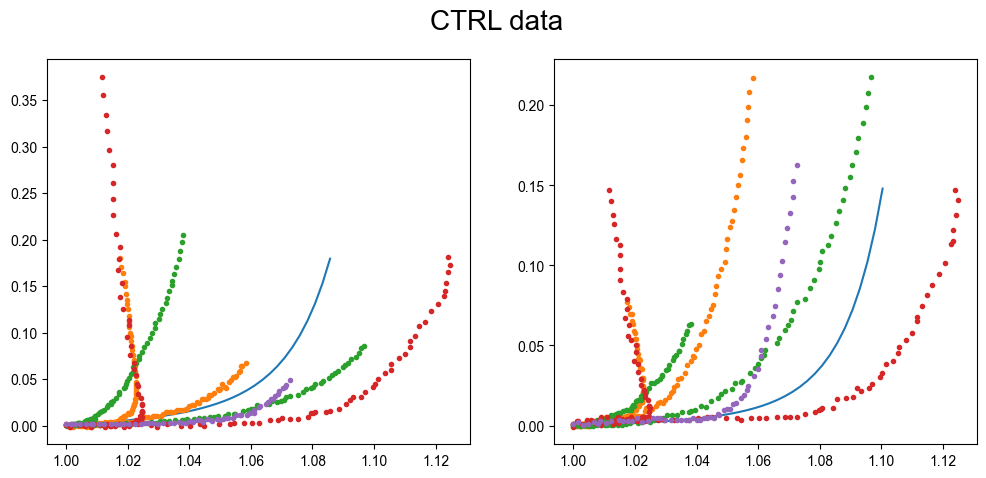

In [21]:
params_i = posterior_samples['params_i']
params_i = params_i[:,:3,:]
params_i = params_i.reshape([-1,9])
params_i = np.median(params_i,axis=0)
print(params_i)

# plot with the median of params_g
lmy = np.linspace(1.0,1.12)
lmx = np.sqrt(lmy)
lmz = 1.0/(lmx*lmy)

sgmx_pr, sgmy_pr = GOH_vmap2(params_i, lmx, lmy, lmz)

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(lmy[0:-14],sgmx_pr[0:-14])
ax[1].plot(lmy[0:-8],sgmy_pr[0:-8])

for i_sample in [0,1,2,3]:   

    idx = data[0,:]==i_sample
    x = data[2,idx]
    # print(x)
    sgmx_gt = data[3,idx] ##sigma real

    sgmy_gt = data[4,idx]
    ax[1].plot(x,sgmy_gt,'.')
    ax[0].plot(x,sgmx_gt,'.')

fig.suptitle('CTRL data', fontsize= 20)
plt.savefig("CTRL_data_pred",dpi=300)